In [36]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import seaborn as sns

In [12]:
src = "../data"
fname = "KnowWho_profiles_merged_twitter.csv"
knowwho_profiles = pd.read_csv(
    Path(src, fname), 
    dtype={"author_id":str},
    parse_dates=["created_at", "ELECTIONDATE"]
)

In [13]:
knowwho_profiles = knowwho_profiles[knowwho_profiles["STATUS"] == "Running"].reset_index(drop=True)
knowwho_profiles = knowwho_profiles.drop(columns=["STATUS", "ELECTIONCODE"])
knowwho_profiles = knowwho_profiles.dropna(subset=["handle"])
len(knowwho_profiles)

1204

In [14]:
fname = "midterm_tweets_2022-01-01_to_2023-05-01.csv.gzip"
tweets = pd.read_csv(
    Path(src, fname),
    dtype={"id":str, "author_id":str},
    parse_dates=["created_at"],
    compression="gzip"
)

In [15]:
knowwho_profiles = knowwho_profiles.set_index(["handle", "ELECTIONDATE"])

In [16]:
# the data set used for the actual analysis
i = 0
data = pd.DataFrame()
for handle, electiondate in knowwho_profiles.index:
    if i%100 == 0:
        print(f"{i}/{len(knowwho_profiles)}")
    candidate_tweets = tweets[tweets["handle"] == handle]
    candidate_tweets_before = candidate_tweets[
        (candidate_tweets["created_at"].dt.date <= electiondate.date()) & \
        (candidate_tweets["created_at"].dt.date >= electiondate.date() - pd.Timedelta(days=28))
    ]
    candidate_tweets_after = candidate_tweets[
        (candidate_tweets["created_at"].dt.date > electiondate.date()) & \
        (candidate_tweets["created_at"].dt.date <= electiondate.date() + pd.Timedelta(days=28))
    ]
    data = pd.concat([data, candidate_tweets_before, candidate_tweets_after])
    i += 1
data = data.reset_index(drop=True)

0/1204
100/1204
200/1204
300/1204
400/1204
500/1204
600/1204
700/1204
800/1204
900/1204
1000/1204
1100/1204
1200/1204


In [17]:
# the pilot data set with tweets from at least 16 weeks before election dates
pilot1 = pd.DataFrame()
# the pilot data set with tweets from at least 16 weeks after election dates
pilot2 = pd.DataFrame()

i = 0
for handle, electiondate in knowwho_profiles.index:
    if i%100 == 0:
        print(f"{i}/{len(knowwho_profiles)}")
    candidate_tweets = tweets[tweets["handle"] == handle]
    candidate_tweets_before = candidate_tweets[
        (candidate_tweets["created_at"].dt.date <= electiondate.date() - pd.Timedelta(days=16 * 7))
    ].copy()
    candidate_tweets_after = candidate_tweets[
        (candidate_tweets["created_at"].dt.date >= electiondate.date() + pd.Timedelta(days=16 * 7))
    ].copy()
    pilot1 = pd.concat([pilot1, candidate_tweets_before])
    pilot2 = pd.concat([pilot2, candidate_tweets_after])
    i += 1

pilot1 = pilot1.reset_index(drop=True)
pilot2 = pilot2.reset_index(drop=True)

0/1204
100/1204
200/1204
300/1204
400/1204
500/1204
600/1204
700/1204
800/1204
900/1204
1000/1204
1100/1204
1200/1204


In [240]:
pilot1["time period"] = "pilot data before"
pilot2["time period"] = "pilot data after"
data["time period"] = "study data"
plot_data = pd.concat([pilot1, pilot2, data])
plot_data = plot_data.reset_index()

In [ ]:
knowwho_profiles = knowwho_profiles.reset_index() 

In [242]:
def plot_election_dates(ax, knowwho_profiles, start_date, end_date):
    bins = pd.date_range(start=start_date, end=end_date,freq='ME')
    n, b, patches = ax.hist(
        knowwho_profiles["ELECTIONDATE"], 
        bins=bins, 
        rwidth=0.8, 
        color=(0.7, 0.7, 0.7),
        align="left"
    )
    ax.set_xlabel('')
    ax.set_ylabel('election count')
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xlim(start_date, end_date)
    ax.set_ylim(0, 500)
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%B %Y'))
    ax.set_xticklabels(["Jan 2022", "March 2022", "May 2022", "July 2022", 
                        "Sept 2022", "Nov 2022", "Jan 2023", "March 2023", "May 2023"])
    ax.tick_params(axis='x', rotation=45, which='major')

    return patches

In [245]:
def plot_tweet_density(ax, plot_data, start_date, end_date):
    kde_plot = sns.kdeplot(
        data=plot_data,
        ax=ax2,
        x="created_at",
        hue="time period",
        palette="Set2",
        linewidth=0,
        fill=True,
        alpha=.5,
        hue_order=["pilot data before", "study data", "pilot data after"],
    )
    ax.set_ylabel("tweet density")
    ax.spines[['left', 'top']].set_visible(False)
    ax.set_xlim(start_date, end_date)
    ax.set_ylim(0, 0.004)

    return kde_plot

/tmp/ipykernel_990012/2572752716.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Jan 2022", "March 2022", "May 2022", "July 2022",


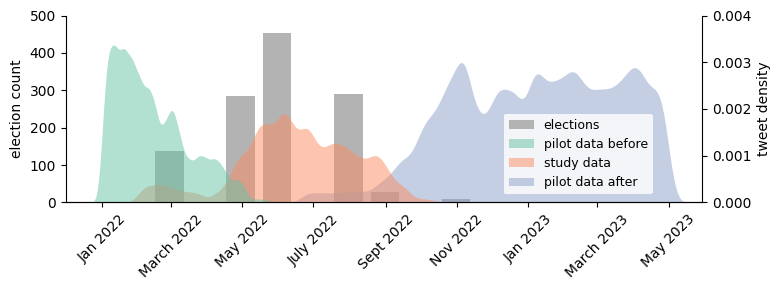

In [256]:
fig, ax1 = plt.subplots(figsize=(8, 3))
ax2 = ax1.twinx()

start_date = pd.to_datetime('2021-12-01')
end_date = pd.to_datetime('2023-05-30')

kde_plot = plot_tweet_density(ax2, plot_data, start_date, end_date)
patches = plot_election_dates(ax1, knowwho_profiles, start_date, end_date)

# legend
kde_lines = kde_plot.lines
handles1 = [patches[0]]
labels1 = ["elections"]
handles2 = kde_plot.legend_.legend_handles
labels2 = [t.get_text() for t in kde_plot.legend_.texts]
all_handles = handles1 + handles2
all_labels = labels1 + labels2

leg = fig.legend(
    all_handles, 
    all_labels, 
    loc=7, 
    bbox_to_anchor=(0.83, 0.47, 0, 0),
    facecolor='white', 
    edgecolor='none',
    fontsize=9
)
ax2.legend_.remove() # remove legend created by seaborn
fig.tight_layout()

fname = "data_distribution"
dst = "../plots"
plt.savefig(Path(dst, fname + ".pdf"))
plt.savefig(Path(dst, fname + ".svg"))